In [1]:
from thllib import flylib as flb
from matplotlib import pyplot as plt
import numpy as np
import scipy
from thllib import util
import figurefirst as fifi
import scipy.signal
import local_project_functions as lpf
from IPython.display import SVG,display

In [2]:
%matplotlib inline

In [3]:
flynumbers = list(range(1389,1402))
flylist = [flb.NetFly(fnum,rootpath='/media/imager/FlyDataD/FlyDB/') for fnum in flynumbers]
l = [fly.open_signals() for fly in flylist]
#fly = flylist[4]
#fly.open_signals()

/home/imager/.local/lib/python2.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in log


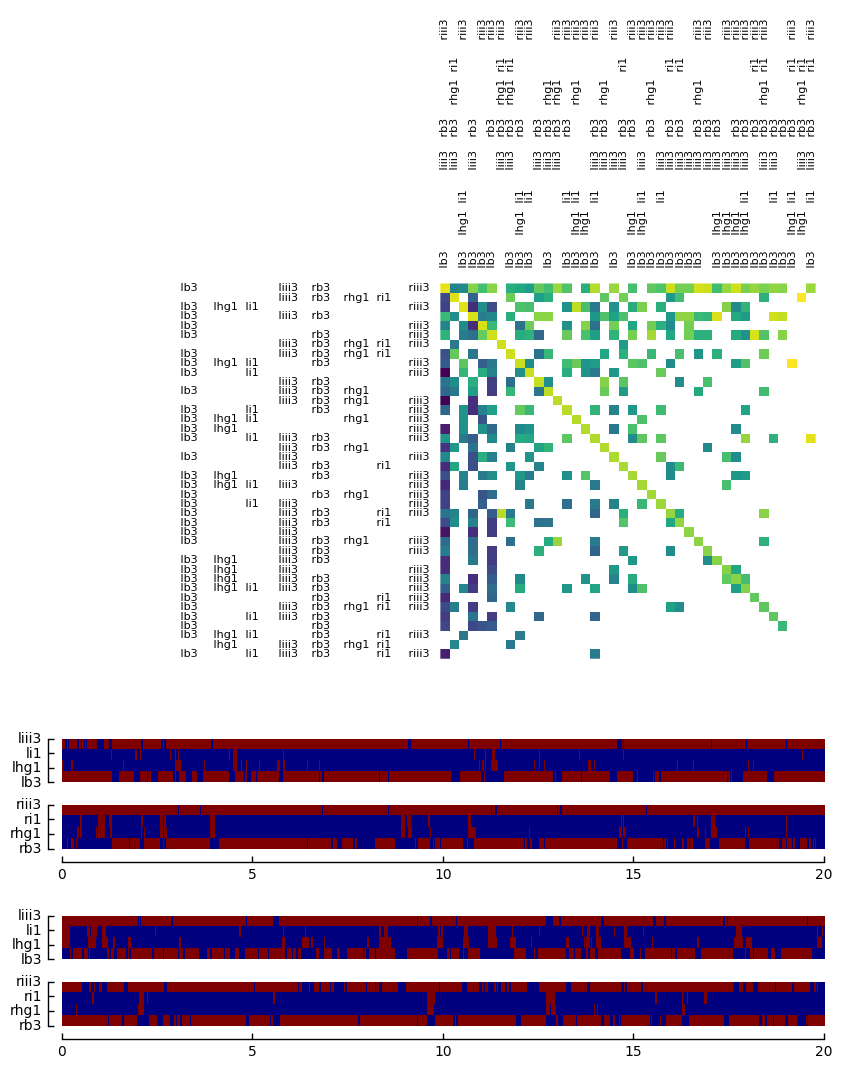

In [5]:
layout = fifi.FigureLayout('markov_analysis_layout.svg',make_mplfigures = True)
#plt.close('all')

ax_tmtrx = layout.axes['transition_mtrx']
ax_lbls_left = layout.axes['state_labels_left']
ax_lbls_top = layout.axes['state_labels_top']

ax_observed_left = layout.axes[u'observed_states', u'left']
ax_observed_right = layout.axes[u'observed_states', u'right']
ax_sim_left = layout.axes[u'simulated_states', u'left']
ax_sim_right = layout.axes[u'simulated_states', u'right']

sorted_keys = sorted(flylist[0].spikestates.keys())

cull_list = [('left', 'bkg'),('right', 'bkg'),
            ('left', 'iii24'),('right', 'iii24'),
            ('left', 'nm'),('right', 'nm'),
            ('left', 'pr'),('right', 'pr'),
            ('left', 'tpd'),('right', 'tpd'),
            ('left', 'iii1'),('right', 'iii1'),
            ('left', 'i2'),('right', 'i2'),
            ('left', 'b1'),('right', 'b1'),
            ('left', 'b2'),('right', 'b2'),
            ('left', 'hg2'),('right', 'hg2'),
            ('left', 'hg3'),('right', 'hg3'),
            ('left', 'hg4'),('right', 'hg4')]

for cull in cull_list:
    sorted_keys.remove(cull)

state_mtrx,left,right = lpf.make_state_matrix(flylist,sorted_keys,
                                 block_key = 'cl_blocks, g_x=-1, g_y=0 b_x=0, b_y=0')

tprob,state_counts = lpf.get_transiton_prob(state_mtrx)

transition_mtrx,state_table = lpf.make_transition_matrix(tprob,state_counts,min_state_num = 10,min_tran_num = 1)

simulated_state_list = [state_table[10]]

for i in range(5000):
    simulated_state_list.append(lpf.next_state(simulated_state_list[-1],
                                           state_table,
                                           transition_mtrx))
simulated_states = np.array(simulated_state_list).T


extnt = [0,0.02*1000,0,3]
ax_observed_left.imshow(state_mtrx[:4,2000:3000],aspect = 'auto',interpolation = 'nearest',extent = extnt)
ax_observed_right.imshow(state_mtrx[4:,2000:3000],aspect = 'auto',interpolation = 'nearest',extent = extnt)
ax_observed_left.set_yticks(range(4))
ax_observed_left.set_yticklabels(['%s%s'%(k[0][0],k[1]) for k in sorted_keys[:4]])
ax_observed_right.set_yticks(range(4))
ax_observed_right.set_yticklabels(['%s%s'%(k[0][0],k[1]) for k in sorted_keys[4:]])

ax_sim_left.imshow(simulated_states[:4,2000:3000],aspect = 'auto',interpolation = 'nearest',extent = extnt)
ax_sim_right.imshow(simulated_states[4:,2000:3000],aspect = 'auto',interpolation = 'nearest',extent = extnt)
ax_sim_left.set_yticks(range(4))
ax_sim_left.set_yticklabels(['%s%s'%(k[0][0],k[1]) for k in sorted_keys[:4]])
ax_sim_right.set_yticks(range(4))
ax_sim_right.set_yticklabels(['%s%s'%(k[0][0],k[1]) for k in sorted_keys[4:]])

ax_tmtrx.imshow(np.log(transition_mtrx),interpolation = 'none',
          cmap = plt.cm.viridis)
#plt.gca().set_yticks(range(state_table.shape[1]))
#ax_lbls_left.imshow(state_table, extent =  [0,0,state_table.shape[1]*3,state_table.shape[0]])
for row,state in enumerate(state_table[::-1]):
    for i,onoff in enumerate(state):
        ax_lbls_left.text(3*i+1,row+1,{0:'',1:' %s%-5s'%(sorted_keys[i][0][0],
                                                sorted_keys[i][1])}[onoff],
                          fontsize = 8,
                          horizontalalignment='left',
                          verticalalignment='bottom')
        
for col,state in enumerate(state_table):
    for i,onoff in enumerate(state):
        ax_lbls_top.text(col+1,3*i+1,{0:'',1:' %s%-5s'%(sorted_keys[i][0][0],
                                                sorted_keys[i][1])}[onoff],
                          fontsize = 8,rotation = 90,
                          horizontalalignment='left',
                          verticalalignment='bottom')

ax_lbls_left.set_xbound(state_table.shape[1]*3)
ax_lbls_left.set_ybound(state_table.shape[0]+1)

ax_lbls_top.set_ybound(state_table.shape[1]*3)
ax_lbls_top.set_xbound(state_table.shape[0]+0.9)
fifi.mpl_functions.set_spines(layout)

In [539]:
np.shape(state_mtrx)

(8, 20650)

In [540]:
from thllib import util

In [541]:
left = util.fill_nan(left)
right = util.fill_nan(right)

In [542]:
kernel_len = 50
left_features = []
right_features = []
for idx in np.arange(kernel_len):
    mt =state_mtrx[:4,idx:-1*kernel_len+idx]
    left_features.append(mt)
    mt =state_mtrx[4:,idx:-1*kernel_len+idx]
    right_features.append(mt)

In [574]:
strt = 0
stop = 10000
left_ = left[strt:stop]
right_ = right[strt:stop]

A_L = np.vstack(left_features)[:,strt:stop]
inv_L = np.linalg.pinv(A_L.T)
X_L = np.dot(inv_L,left_)#[:-1*kernel_len])

A_R = np.vstack(right_features)[:,strt:stop]
inv_R = np.linalg.pinv(A_R.T)
X_R = np.dot(inv_R,right_)#[:-1*kernel_len])

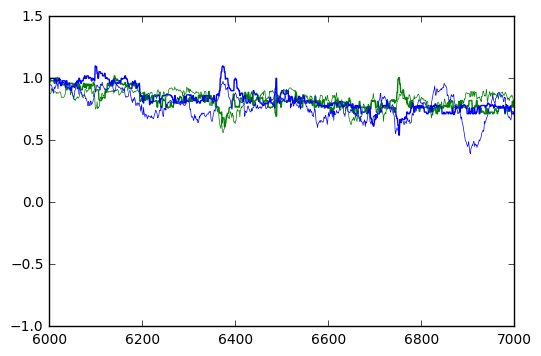

In [588]:
plt.plot(left_,'g')
plt.plot(right_,'b')
plt.plot(np.dot(A_L.T,X_L),'green',lw = 0.5)
plt.plot(np.dot(A_R.T,X_R),'b',lw = 0.5)
plt.gca().set_xbound(6000,7000)

In [22]:
s0_idx+2

array([   50,    51,    52, ..., 20637, 20640, 20651])

In [18]:
s0 = np.array([1,0,0,1,1,0,0,1])
s1 = np.array([1,1,1,0,0,0,0,1])
s2 = np.array([0,0,0,1,1,1,1,0])
s0_idx = np.squeeze(np.argwhere(np.all(state_mtrx == s0[:,None],axis = 0)))
s1_idx = np.squeeze(np.argwhere(np.all(state_mtrx == s1[:,None],axis = 0)))
s2_idx = np.squeeze(np.argwhere(np.all(state_mtrx == s2[:,None],axis = 0)))

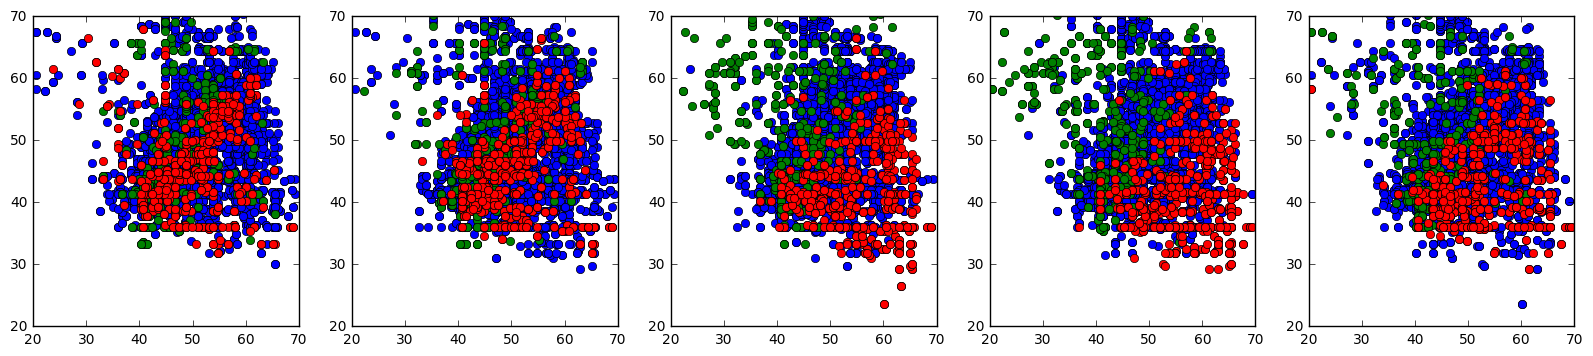

In [36]:
plt.figure(figsize = (24,4))
sh = 5
plt.subplot(1,6,1)
for sh in range(5):
    plt.subplot(1,6,1+sh)
    sh -=2
    plt.plot(np.rad2deg(np.vstack(left)[s0_idx[:-50]+sh*8]),
             np.rad2deg(np.vstack(right)[s0_idx[:-50]+sh*8]),'o')
    plt.plot(np.rad2deg(np.vstack(left)[s1_idx[:-50]+sh*8]),
             np.rad2deg(np.vstack(right)[s1_idx[:-50]+sh*8]),'o')
    plt.plot(np.rad2deg(np.vstack(left)[s2_idx[:-50]+sh*8]),
             np.rad2deg(np.vstack(right)[s2_idx[:-50]+sh*8]),'o')
    plt.gca().set_xbound(20,70)
    plt.gca().set_ybound(20,70)